In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score

from collections import Counter


In [46]:
with open('COMET_API_KEY.txt', 'r') as f:
    key = f.read()
## Create an experiment with your api key
from comet_ml import Experiment
experiment = Experiment(
    api_key=key,
    project_name="nhl-analytics",
    workspace="ift6758-22-team2",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-22-team2/nhl-analytics/f9b4608171ce4bacb0a8659f1ee3142e



COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


In [2]:
def logreg_fit(X_train, X_valid, y_train, y_valid):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_valid)
    predicted_prob = clf.predict_proba(X_valid)
    score = clf.score(X_valid, y_valid)
    return clf, y_pred, predicted_prob[:,1]


In [3]:
df_dataset = pd.read_csv('df_dataset.csv')
df_dataset.dropna(axis=0,subset = ['shot_angle_absolute'],inplace=True)
X_df_dataset = df_dataset[['distanceNet_or_shotDistance','shot_angle_absolute']]
y_df_dataset = df_dataset['goal']
X_dataset = X_df_dataset.to_numpy()
y_dataset = y_df_dataset.to_numpy()
print(X_dataset,y_dataset)

X_train, X_valid, y_train, y_valid = train_test_split(X_dataset,y_dataset,test_size=0.25,random_state=10, shuffle = True)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

[[34.525353   10.0079798 ]
 [10.          0.        ]
 [14.03566885  4.08561678]
 ...
 [24.0208243   2.38594403]
 [24.18677324  7.12501635]
 [19.10497317  6.00900596]] [0 0 0 ... 0 1 0]
(285226, 2) (285226,)
(95076, 2) (95076,)


In [4]:
print(np.isnan(df_dataset['shot_angle_absolute']).sum())
print(df_dataset.shape)

0
(380302, 34)


In [5]:
'''
logreg for distanceNet = d
logreg for angle = a
logreg for distance and angle = da
Random baseline = r
'''
#logreg
logreg_d, y_pred_d, predicted_prob_d = logreg_fit(X_train[:,0].reshape(-1,1), X_valid[:,0].reshape(-1,1), y_train, y_valid)
logreg_a, y_pred_a, predicted_prob_a = logreg_fit(X_train[:,1].reshape(-1,1), X_valid[:,1].reshape(-1,1), y_train, y_valid)
logreg_da, y_pred_da, predicted_prob_ad = logreg_fit(X_train, X_valid, y_train, y_valid)
#Random baseline
y_prob_r= np.random.uniform(0,1,y_pred_da.shape)
y_pred_r = np.where(y_prob_r > 0.5, 1, 0)

save models

In [51]:
if not os.path.exists('models/'):
    os.mkdir('models/')
pickle.dump(logreg_d, open('models/logreg_dist.sav', 'wb'))
pickle.dump(logreg_a, open('models/logreg_angle.sav', 'wb'))
pickle.dump(logreg_da, open('models/logreg_dist_angle.sav', 'wb'))

In [52]:
experiment.log_model("logreg with distance", 'models/logreg_dist.sav')
experiment.log_model("logreg with angle", 'models/logreg_angle.sav')
experiment.log_model("logreg with distance and angle", 'models/logreg_dist_angle.sav')


{'web': 'https://www.comet.com/api/asset/download?assetId=f5c62a8001e149639fc4175175cdb94e&experimentKey=f9b4608171ce4bacb0a8659f1ee3142e',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=f5c62a8001e149639fc4175175cdb94e&experimentKey=f9b4608171ce4bacb0a8659f1ee3142e',
 'assetId': 'f5c62a8001e149639fc4175175cdb94e'}

In [6]:
models = ['logreg for distanceNet', 'logreg for angle', 'logreg for distance and angle', 'Random baseline']
models_pred = [y_pred_d, y_pred_a, y_pred_da, y_pred_r]
models_prob = [predicted_prob_d, predicted_prob_a, predicted_prob_ad, y_prob_r]

In [7]:
sn.set()

Evaluate the accuracy for logreg distanceNet

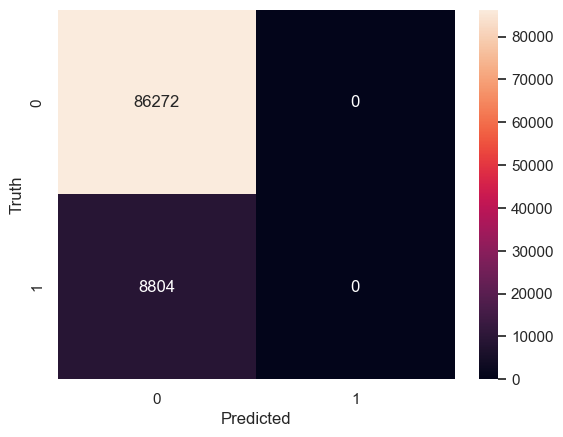

In [8]:
cmLogreg = confusion_matrix(y_valid , y_pred_d)
logreg_d_confmatrix = plt.figure()
sn.heatmap(cmLogreg ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
logreg_d.score(X_valid[:,0].reshape(-1,1),y_valid)
logreg_d_confmatrix.savefig('M2_Q3_01.png')

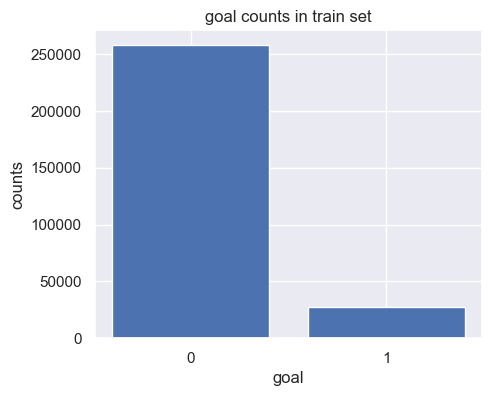

In [9]:
#What could be a potential issue?
#Class Imbalance
trainlabel = plt.figure(figsize=(5,4))
y = Counter(y_train)
plt.bar(y.keys(), y.values())
plt.title('goal counts in train set')
plt.xlabel('goal')
plt.ylabel('counts')
plt.xticks([0,1])
trainlabel.savefig('M2_Q3_02.png')

2 and 3 : Four figure each have four curves

a. Receiver Operating Characteristic (ROC) curves and the AUC metric of the ROC
curve. Include a random classifier baseline, i.e. each shot has a 50% chance of
being a goal.

In [10]:
# Compute ROC curve and ROC area for each class for 4 models
n_classes = 2
fpr_list = []
tpr_list = []
roc_auc_list = []

# Compute micro-average ROC curve and ROC area for 4 models
for i in range(len(models)):
    fpr, tpr, _ = roc_curve(y_valid.ravel(), models_prob[i].ravel())
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

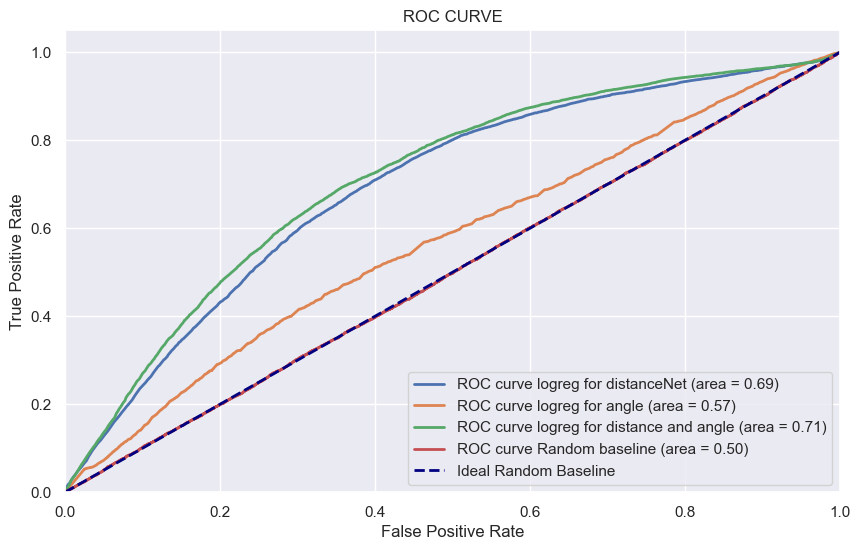

In [11]:
roc_auc_plot = plt.figure(figsize=(10,6))
lw = 2
for i in range(len(models)):
    plt.plot(
        fpr_list[i],
        tpr_list[i],
        lw=lw,
        label="ROC curve %s (area = %0.2f)" % (models[i], roc_auc_list[i])
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, label="Ideal Random Baseline",linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right")
roc_auc_plot.savefig('M2_Q3_1.png')

b. The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability
model percentile, i.e. if a value is the 70th percentile, it is above 70% of the data.

In [12]:
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))
print(bins)
print(bin_centers)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 72.5, 77.5, 82.5, 87.5, 92.5, 97.5]


In [13]:
#prepare dataframe for plot b,c,d
df_prob_list = []
df_prob_bined_list = []

for i in range(len(models)):
    df_prob = pd.DataFrame(list(zip(models_pred[i], y_valid, models_prob[i]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()
    df_prob['percentile'] = df_prob['goal_Prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
    df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
    df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
    df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
    df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()

    df_prob_list.append(df_prob)
    df_prob_bined_list.append(df_prob_bined)

C:\Users\haooy\AppData\Local\Temp\ipykernel_74904\19145864.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  goal_rate_plot.show()


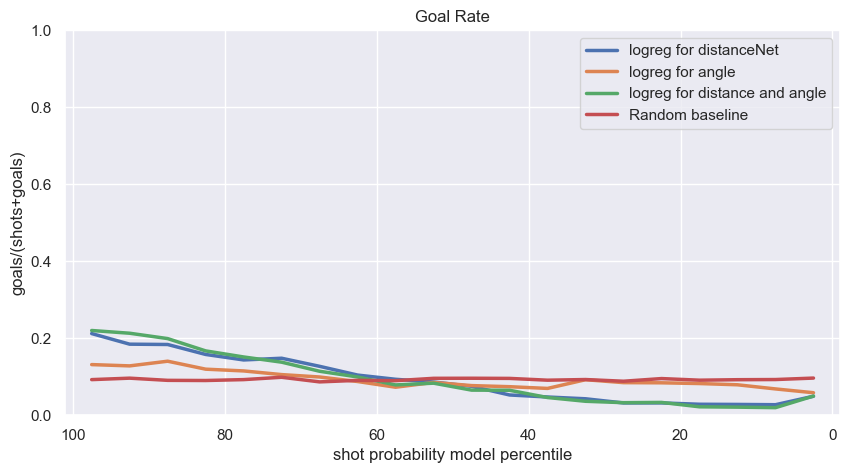

In [14]:
goal_rate_plot = plt.figure(figsize = (10,5))
plt.title(f"Goal Rate")
for i in range(len(models)):
    ax = sn.lineplot(
        x = 'goal_perc_bins', 
        y = 'goal_rate', 
        data = df_prob_bined_list[i], 
        legend = False, 
        linewidth = 2.5,
        label="%s" % (models[i])
    )
plt.xlabel('shot probability model percentile')
plt.ylabel('goals/(shots+goals)')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=0, top=1)
goal_rate_plot.legend(bbox_to_anchor=(0.9, 0.88))
plt.xticks(np.arange(0,120,20))
goal_rate_plot.show()
goal_rate_plot.savefig('M2_Q3_2.png')

c. The cumulative proportion of goals (not shots) as a function of the shot
probability model percentile.

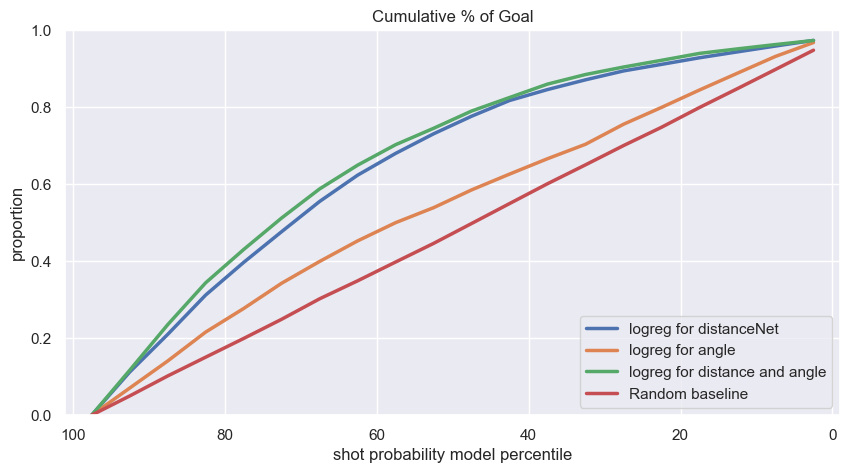

In [15]:
cum_rate_plot = plt.figure(figsize = (10,5))
plt.title(f"Cumulative % of Goal")
for i in range(len(models)):
    ax = sn.lineplot(
        x = 'goal_perc_bins', 
        y = 'goal_cumsum', 
        data = df_prob_bined_list[i], 
        legend = False, 
        label="%s" % (models[i]),
        linewidth = 2.5)
plt.legend(loc="lower right")
plt.xlabel('shot probability model percentile')
plt.ylabel('proportion')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=0, top=1)
plt.xticks(np.arange(0,120,20))
plt.show()
cum_rate_plot.savefig('M2_Q3_3.png')

d. The reliability diagram (calibration curve). Scikit-learn provides functionality to
create a reliability diagram in a few lines of code; check out the
CalibrationDisplay API (specifically the .from_estimator() or
.from_predictions() methods) for more information.

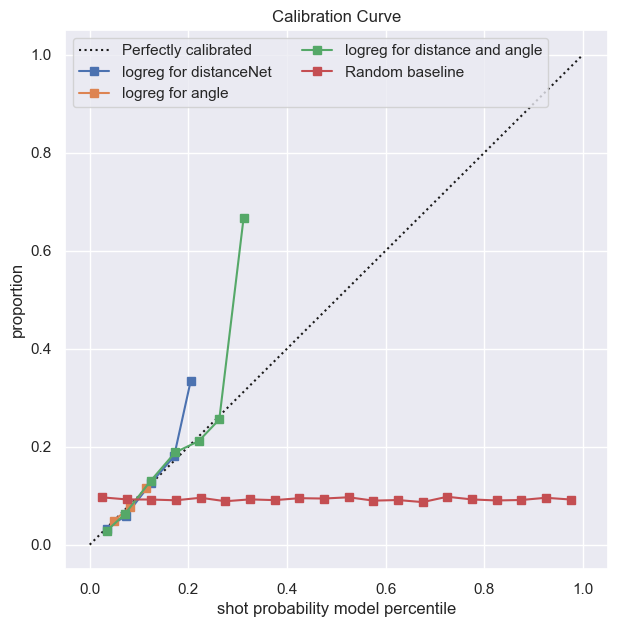

In [16]:
calibration_plot = plt.figure(figsize = (7,7))
plt.title(f"Calibration Curve")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for i in range(len(models)):
    prob_true, prob_pred = calibration_curve(df_prob_list[i]['goal'], df_prob_list[i]['goal_Prob']/100, n_bins=20)
    plt.plot(
        prob_pred, 
        prob_true, 
        "s-",
        label="%s" % (models[i]))
plt.xlabel('shot probability model percentile')
plt.ylabel('proportion')
plt.legend(loc="upper left", ncol=2)
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)
plt.xticks(np.arange(0,1.2,0.2))
plt.yticks(np.arange(0,1.2,0.2))
plt.show()
calibration_plot.savefig('M2_Q3_4.png')

upload plots

In [64]:
experiment.log_figure(figure=logreg_d_confmatrix, overwrite=False)
experiment.log_figure(figure=trainlabel, overwrite=False)
experiment.log_figure(figure=roc_auc_plot, overwrite=False)
experiment.log_figure(figure=goal_rate_plot, overwrite=False)
experiment.log_figure(figure=cum_rate_plot, overwrite=False)
experiment.log_figure(figure=calibration_plot, overwrite=False)

{'web': 'https://www.comet.com/api/image/download?imageId=10e9b894da384b3ab7fc33391b5de1e9&experimentKey=f9b4608171ce4bacb0a8659f1ee3142e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=10e9b894da384b3ab7fc33391b5de1e9&experimentKey=f9b4608171ce4bacb0a8659f1ee3142e',
 'imageId': '10e9b894da384b3ab7fc33391b5de1e9'}

In [65]:
experiment.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x0000023AB7144880>>